In [1]:
import tensorflow as tf
import glob
from matplotlib import pyplot as plt
%matplotlib inline
import os
import concurrent.futures
import random
import time
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image as im
from skimage.filters import threshold_otsu, threshold_multiotsu

2024-03-02 18:04:34.997056: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-02 18:04:34.997269: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-02 18:04:35.052147: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-02 18:04:35.164296: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-02 18:04:36.279269: W tensorflow/comp

In [2]:
print("TensorFlow version:", tf.__version__)

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    print("Active GPU devices:")
    for gpu in gpus:
        print("  -", gpu.name)
else:
    print("No GPU devices found.")

TensorFlow version: 2.15.0
Active GPU devices:
  - /physical_device:GPU:0
  - /physical_device:GPU:1


In [3]:
aug_dir = "/home/ifang/HEDS/data/cycleGAN/AugmentedData_cycleGAN_real_thresholded"


A_paths = sorted( 
    [
        os.path.join(aug_dir, fname)
        for fname in os.listdir(aug_dir)
        if "real_images_" in fname and "groundtruth_"  in fname
    ]
)

B_paths = sorted( 
    [
        os.path.join(aug_dir, fname)
        for fname in os.listdir(aug_dir)
        if "groundtruth_" not in fname
    ]
)

In [4]:
len(A_paths)

1000

In [5]:
len(B_paths)

1000

In [9]:
train_A_paths, test_A_paths, train_B_paths, test_B_paths = train_test_split(A_paths, B_paths,
                                                  test_size=0.2,
                                                  random_state=0
                                                  )

In [10]:
IMSIZE = 256

def segment_two_phase(image):
    otsu_thresh = threshold_otsu(image)
    binary_image = np.zeros_like(image)
    binary_image[image > otsu_thresh] = 128 
    return binary_image
    

def read_img_a(path):
    img = tf.keras.utils.load_img(path, color_mode='grayscale', target_size=(IMSIZE, IMSIZE))
    np_img = np.array(img)
    thresh_img = segment_two_phase(np_img)
    return thresh_img
    
def prepare_dataset_a(namelist):
    start = time.time()
    imgs = []
    with concurrent.futures.ThreadPoolExecutor(max_workers = 16) as executor:
        i = 0
        for value in executor.map(read_img_a, namelist):
            i+=1
            print("\rFetching: [{}/{}]".format(i, len(namelist)), end="", flush=True)
            imgs.append(value)
        imgs = np.stack(imgs)
        imgs = tf.convert_to_tensor(imgs)
        imgs = tf.expand_dims(imgs,axis=-1)
    print("\nExecution time: ",time.time() - start, "s")
    return imgs

In [12]:
with tf.device('/gpu:0'):
    train_a= prepare_dataset_a(train_A_paths)
    test_a= prepare_dataset_a(test_A_paths)
print("Training A tensor shape", train_a.shape)
print("Testing A tensor shape", test_a.shape)

Fetching: [55/800]

2024-03-02 18:04:38.597316: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 19058 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:17:00.0, compute capability: 8.6
2024-03-02 18:04:38.598436: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22452 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:65:00.0, compute capability: 8.6


Fetching: [800/800]
Execution time:  0.8471469879150391 s
Fetching: [200/200]
Execution time:  0.19283699989318848 s
Training A tensor shape (800, 256, 256, 1)
Testing A tensor shape (200, 256, 256, 1)


In [13]:
def segment_three_phase(diff_image):
    thresholds = threshold_multiotsu(diff_image, classes=3)
    colorized_image = np.full(diff_image.shape, 128, dtype=np.uint8)  # Gray
    colorized_image[diff_image <= thresholds[0]] = 0  # Black
    colorized_image[diff_image > thresholds[1]] = 255  # White
    return colorized_image
    
def read_img_b(path):
    img = tf.keras.utils.load_img(path, color_mode='grayscale', target_size=(IMSIZE, IMSIZE))
    np_img = np.array(img)
    thresh_img = segment_three_phase(np_img)
    return thresh_img
    
def prepare_dataset_b(namelist):
    start = time.time()
    imgs = []
    with concurrent.futures.ThreadPoolExecutor(max_workers = 16) as executor:
        i = 0
        for value in executor.map(read_img_b, namelist):
            i+=1
            print("\rFetching: [{}/{}]".format(i, len(namelist)), end="", flush=True)
            imgs.append(value)
        imgs = np.stack(imgs)
        imgs = tf.convert_to_tensor(imgs)
        imgs = tf.expand_dims(imgs,axis=-1)
    print("\nExecution time: ",time.time() - start, "s")
    return imgs

In [14]:
with tf.device('/gpu:0'):
    train_b= prepare_dataset_b(train_B_paths)
    test_b= prepare_dataset_b(test_B_paths)
print("Training A tensor shape", train_b.shape)
print("Testing A tensor shape", test_b.shape)

Fetching: [800/800]
Execution time:  0.7150726318359375 s
Fetching: [200/200]
Execution time:  0.18353867530822754 s
Training A tensor shape (800, 256, 256, 1)
Testing A tensor shape (200, 256, 256, 1)


In [15]:
np.unique(train_a)

array([  0, 128], dtype=uint8)

In [16]:
np.unique(train_b)

array([  0, 128, 255], dtype=uint8)

In [17]:
def map(image):
    image = tf.cast(image, tf.float32)
    image = image / 255
    image = image * 2 - 1
    return image

In [18]:
train_a = tf.data.Dataset.from_tensor_slices(train_a)
train_b = tf.data.Dataset.from_tensor_slices(train_b)
test_a = tf.data.Dataset.from_tensor_slices(test_a)
test_b = tf.data.Dataset.from_tensor_slices(test_b)

In [19]:
AUTOTUNE = tf.data.AUTOTUNE
BUFFER_SIZE = 200

train_a = train_a.map(map, num_parallel_calls=AUTOTUNE).shuffle(BUFFER_SIZE).batch(1).prefetch(AUTOTUNE)
train_b = train_b.map(map, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(1).prefetch(AUTOTUNE)
test_a = test_a.map(map, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(1).prefetch(AUTOTUNE)
test_b = test_b.map(map, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(1).prefetch(AUTOTUNE)

In [20]:
train_dataset = tf.data.Dataset.zip((train_a, train_b))
test_dataset = tf.data.Dataset.zip((test_a, test_b))

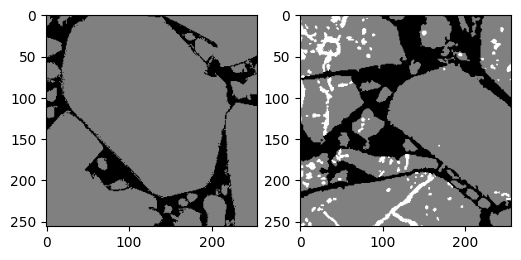

In [21]:
plt.figure(figsize=(6, 3))
for imgs_A, imgs_B in test_dataset.take(1):
    plt.subplot(1,2,1)
    plt.imshow((imgs_A[0]+1)/2, cmap='grey', vmin=0, vmax=1)
    plt.subplot(1,2,2)
    plt.imshow((imgs_B[0]+1)/2, cmap='grey', vmin=0, vmax=1)

In [22]:
def instance_normalization(x, epsilon=1e-5):
    mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
    inv = tf.math.rsqrt(variance + epsilon)
    normalized = (x - mean) * inv
    return normalized

In [23]:
loaded_model = tf.keras.models.load_model('CycleGANv2_three_phase_generator_x.keras',
                                          custom_objects={'instance_normalization': instance_normalization}, 
                                          safe_mode=False)

In [24]:
type(test_a)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

In [25]:
def scale_array_neg1_1_to_0_255(arr):
    scaled_arr = ((arr + 1) * 255 / 2).astype(np.uint8)
    return scaled_arr

In [26]:
def dataset_to_numpy(dataset):
    images = []
    for image_batch in dataset:
        for image in image_batch:
            images.append(image.numpy())
    return np.array(images)

In [27]:
np_test_a = dataset_to_numpy(test_a)

In [28]:
np_test_a.shape

(200, 256, 256, 1)

In [29]:
predictions = loaded_model.predict(np_test_a)

2024-03-02 18:04:52.020460: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-03-02 18:04:52.267409: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-02 18:04:52.814791: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


7/7 [==============================] - 6s 217ms/step


In [30]:
np_test_a_scaled = scale_array_neg1_1_to_0_255(np_test_a)

In [31]:
scaled_preds = scale_array_neg1_1_to_0_255(predictions)

In [32]:
num_samples = 15

In [35]:
from matplotlib.gridspec import GridSpec

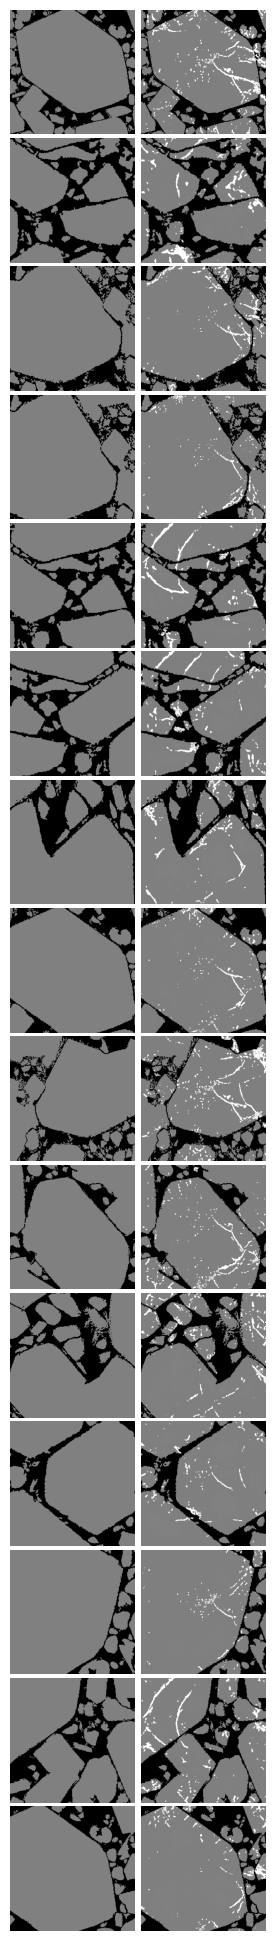

In [36]:
fig = plt.figure(figsize=(3.3, 2*num_samples))
gs = GridSpec(nrows=num_samples, ncols=2, figure=fig, hspace=-0.75, wspace=0.05)

for i in range(num_samples):
    ax1 = fig.add_subplot(gs[i, 0])
    ax2 = fig.add_subplot(gs[i, 1])
    ax1.imshow(np_test_a_scaled[i], cmap='gray', vmin=0, vmax=255)
    ax2.imshow(scaled_preds[i], cmap='gray', vmin=0, vmax=255)
    ax1.set_axis_off()
    ax2.set_axis_off()

plt.show()

In [ ]:
def find_global_thresholds(images):
    all_pixels = images.flatten()
    thresholds = threshold_multiotsu(all_pixels, classes=3)
    return thresholds

In [ ]:
global_thresholds = find_global_thresholds(scaled_preds)

In [ ]:
global_thresholds

In [ ]:
def segment_images(images, thresholds):
    segmented_images = np.zeros_like(images, dtype=np.uint8)
    lower, upper = thresholds
    segmented_images[images <= lower] = 0       # Background
    segmented_images[(images > lower) & (images <= upper)] = 128  # Crystal
    segmented_images[images > upper] = 255      # Damage
    return segmented_images

In [ ]:
segmented_images = segment_images(scaled_preds, global_thresholds)

In [ ]:
segmented_images.shape

In [46]:
from PIL import Image
import random

original_image = Image.open('1.png')
def add_random_pixel(img):
    new_img = img.copy()
    width, height = new_img.size
    random_x = random.randint(0, width - 1)
    random_y = random.randint(0, height - 1)
    random_color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    new_img.putpixel((random_x, random_y), random_color)
    return new_img

for i in range(1, 10):
    modified_image = add_random_pixel(original_image)
    modified_image.save(f'{i+1}.png')

In [64]:
def inject_noise(image_array, noise_scale=0.01):
    if image_array.dtype != np.float32 and image_array.dtype != np.float64:
        image_array = image_array.astype(np.float32)
    
    noise = np.random.normal(loc=0.0, scale=noise_scale, size=image_array.shape)
    noisy_image = image_array + noise
    noisy_image = np.clip(noisy_image, 0, 255)
    return noisy_image

In [127]:
def read_img_a(path):
    img = tf.keras.utils.load_img(path, color_mode='grayscale', target_size=(IMSIZE, IMSIZE))
    np_img = np.array(img)
    thresh_img = segment_two_phase(np_img)
    thresh_img_noisy = inject_noise(thresh_img, noise_scale=10.0)
    return thresh_img_noisy

def prepare_dataset_a(namelist):
    start = time.time()
    imgs = []
    with concurrent.futures.ThreadPoolExecutor(max_workers = 16) as executor:
        i = 0
        for value in executor.map(read_img_a, namelist):
            i+=1
            print("\rFetching: [{}/{}]".format(i, len(namelist)), end="", flush=True)
            imgs.append(value)
        imgs = np.stack(imgs)
        imgs = tf.convert_to_tensor(imgs)
        imgs = tf.expand_dims(imgs,axis=-1)
    print("\nExecution time: ",time.time() - start, "s")
    return imgs

In [128]:
with tf.device('/gpu:0'):
    single_input_set = prepare_dataset_a(['1.png', '2.png','3.png','4.png','5.png','6.png','7.png','8.png','9.png','10.png'])

Fetching: [10/10]
Execution time:  0.04636383056640625 s


In [129]:
AUTOTUNE = tf.data.AUTOTUNE
BUFFER_SIZE = 200

single_input_set = tf.data.Dataset.from_tensor_slices(single_input_set)
single_input_set = single_input_set.map(map, num_parallel_calls=AUTOTUNE).shuffle(BUFFER_SIZE).batch(1).prefetch(AUTOTUNE)

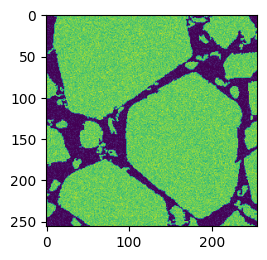

In [130]:
plt.figure(figsize=(6, 3))
for single  in single_input_set.take(1):
    plt.subplot(1,2,1)
    plt.imshow((single[0]+1)/2)

In [131]:
single_input_preds = []
for image in single_input_set:
    predictions = loaded_model(image, training=True)
    predictions_np = predictions.numpy()

    single_input_preds.append(predictions_np[0])

In [132]:
single_input_preds = np.array(single_input_preds)

In [125]:
import matplotlib.image as mpimg

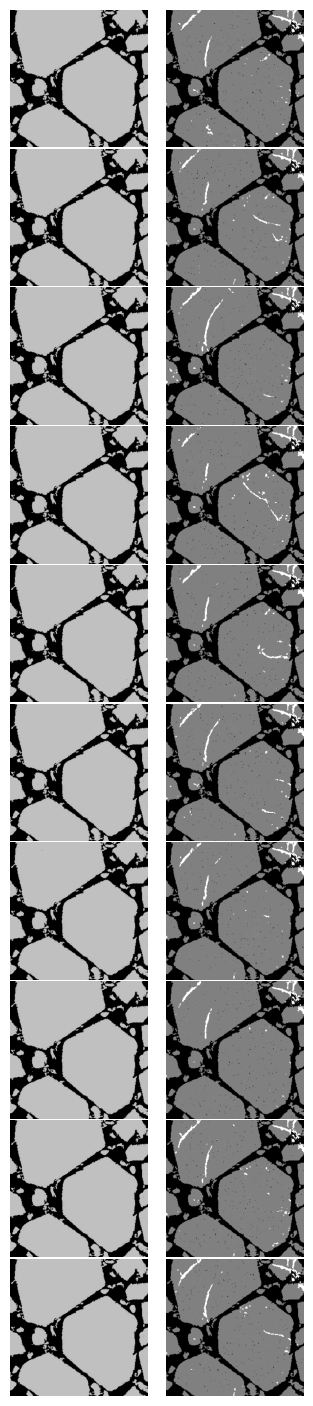

In [133]:
fig, axes = plt.subplots(10, 2, figsize=(4, 18))
inputs = ['1.png', '2.png','3.png','4.png','5.png','6.png','7.png','8.png','9.png','10.png']

for i in range(10):
    img = mpimg.imread(inputs[i])
    ax1 = axes[i,0]
    ax1.imshow(img, cmap='gray')
    ax1.axis('off')
    
    ax2 = axes[i,1]
    ax2.imshow(single_input_preds[i], cmap='gray')  
    ax2.axis('off')

plt.subplots_adjust(wspace=0.01, hspace=0.01)
plt.show()

In [143]:
import cv2

def scale_image(image_array, input_range=(-1, 1), output_range=(0, 255)):
    scaled_image = (image_array - input_range[0]) / (input_range[1] - input_range[0])
    scaled_image = scaled_image * (output_range[1] - output_range[0]) + output_range[0]
    return scaled_image

def denoise_image(image_array, method="gaussian", **kwargs):
    image_scaled = scale_image(image_array, input_range=(-1, 1), output_range=(0, 255)).astype(np.uint8)
    if method == "gaussian":
        kernel_size = kwargs.get('kernel_size', 5)
        denoised_scaled = cv2.GaussianBlur(image_scaled, (kernel_size, kernel_size), 0)
    elif method == "non_local_means":
        h = kwargs.get('h', 10)
        templateWindowSize = kwargs.get('templateWindowSize', 7)
        searchWindowSize = kwargs.get('searchWindowSize', 21)
        if len(image_scaled.shape) == 3:
            denoised_scaled = cv2.fastNlMeansDenoisingColored(image_scaled, None, h, h, templateWindowSize, searchWindowSize)
        else:
            denoised_scaled = cv2.fastNlMeansDenoising(image_scaled, None, h, templateWindowSize, searchWindowSize)
    else:
        raise ValueError("Unsupported denoising method. Choose 'gaussian' or 'non_local_means'.")
    denoised_image = scale_image(denoised_scaled, input_range=(0, 255), output_range=(-1, 1))

    return denoised_image


In [136]:
single_input_preds.shape

(10, 256, 256, 1)

In [137]:
np.min(single_input_preds[0])

-1.0

In [218]:
def remove_black_flecks_within_gray(img):
    image = img
    grey_crystals_mask = image == 128
    black_flecks_mask = (image == 0) & grey_crystals_mask
    kernel = np.ones((7, 7), np.uint8)
    removed_flecks = cv2.morphologyEx(black_flecks_mask.astype(np.uint8), cv2.MORPH_OPEN, kernel)
    image[removed_flecks == 1] = 128
    processed_image = image.reshape((256, 256, 1))
    return processed_image


In [239]:
from scipy.ndimage import label

def remove_noise(image, min_size):
    _, binary_image = cv2.threshold(image, 1, 1, cv2.THRESH_BINARY_INV)
    labeled, num_features = label(binary_image)
    output_image = np.copy(image)
    for i in range(1, num_features + 1):
        if np.sum(labeled == i) < min_size:
            output_image[labeled == i] = 128
    return output_image

In [240]:
from image_processing import prep_dataset, thresholding

In [241]:
adj = prep_dataset.denormalize_neg1_1_to_0_255_uint8(single_input_preds[0])
thresh = thresholding.segment_three_phase(adj)

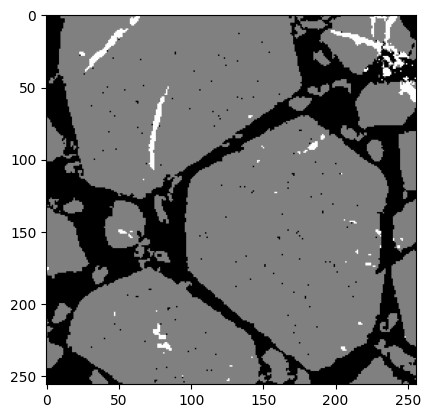

In [242]:
plt.imshow(thresh, cmap='gray')

In [243]:
np.unique(thresh)

array([  0, 128, 255], dtype=uint8)

In [244]:
thresh.shape

(256, 256, 1)

In [245]:
clean = remove_noise(thresh,10)

In [246]:
clean.shape

(256, 256, 1)

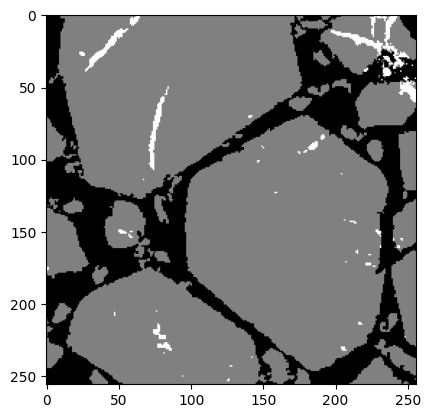

In [247]:
plt.imshow(clean, cmap='gray')

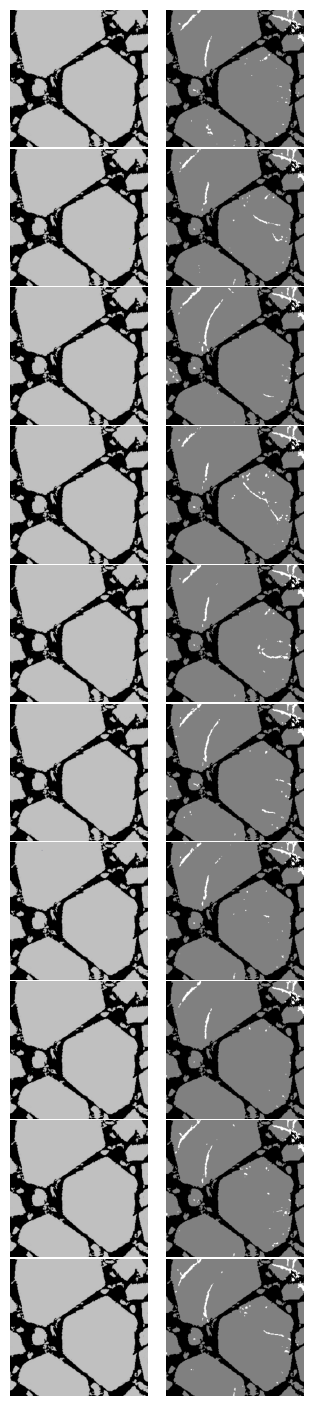

In [249]:
fig, axes = plt.subplots(10, 2, figsize=(4, 18))
inputs = ['1.png', '2.png','3.png','4.png','5.png','6.png','7.png','8.png','9.png','10.png']

for i in range(10):
    img = mpimg.imread(inputs[i])
    ax1 = axes[i,0]
    ax1.imshow(img, cmap='gray')  
    ax1.axis('off')
    ax2 = axes[i,1]
    adj = prep_dataset.denormalize_neg1_1_to_0_255_uint8(single_input_preds[i])
    thresh = thresholding.segment_three_phase(adj)
    denoised_image = remove_noise(thresh, 10)
    ax2.imshow(denoised_image, cmap='gray')  
    ax2.axis('off')

plt.subplots_adjust(wspace=0.01, hspace=0.01)
plt.savefig("cycleGAN_noise_different_outputs_sample_image.png")
plt.show()